In [15]:
%matplotlib inline
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from scipy.misc import derivative

import dm_density_profiles as dmd
import cgs as cgs

import df as df

import time

In [16]:
NFW = dmd.general_dm_profile('Hernquist')
NFW.set_params(profile_shape_params=[1.0,4.0,1.0])
NFW.set_params(M_vir = 1.0E12 * cgs.Msun, r_vir = 240.0 * cgs.kpc)
NFW.set_params(r_decay = 0.1*NFW.r_vir, r_s = (1.0/12.0)*NFW.r_vir)

OK False
OK False
OK True


In [17]:
NFW_DF = df.DF(NFW)

N_DM = 1.0E4
M_DM = NFW.M_vir / N_DM


In [18]:
# find the range of the potential
r = np.linspace(0.0,1000.0,100.0)*cgs.kpc

rel_pot = NFW_DF.relative_potential(r)

# and pick a range of velocities
v = np.linspace(0.0,500.0 * cgs.km,100.0)
v_sqr = v*v

evals_low = rel_pot - np.min(0.5*v_sqr)
evals_high = rel_pot - np.max(0.5*v_sqr)

print np.min(evals_low), np.max(evals_low)
print np.min(evals_high), np.max(evals_high)

print np.min(rel_pot), np.max(rel_pot)

4.95033262938e+13 2.52467051746e+15
-1.20049667371e+15 1.27467051746e+15
4.95033262938e+13 2.52467051746e+15


In [19]:
#E = np.logspace(14, np.log10(1.23E15), 10.0)

In [20]:
start = time.time()

f = NFW_DF.compute(150, M_DM, N_DM)

end = time.time()

print (end-start)/60.0, end-start

000 Computing value for E = 2.337E+11  - f = 1.029E-56
001 Computing value for E = 2.488E+11  - f = 1.308E-56
002 Computing value for E = 2.648E+11  - f = 1.603E-56
003 Computing value for E = 2.818E+11  - f = 1.931E-56
004 Computing value for E = 2.999E+11  - f = 2.302E-56
005 Computing value for E = 3.192E+11  - f = 2.727E-56
006 Computing value for E = 3.397E+11  - f = 3.217E-56
007 Computing value for E = 3.616E+11  - f = 3.785E-56
008 Computing value for E = 3.848E+11  - f = 4.444E-56
009 Computing value for E = 4.096E+11  - f = 5.210E-56
010 Computing value for E = 4.359E+11  - f = 6.103E-56
011 Computing value for E = 4.640E+11  - f = 7.144E-56
012 Computing value for E = 4.938E+11  - f = 8.359E-56
013 Computing value for E = 5.256E+11  - f = 9.776E-56
014 Computing value for E = 5.594E+11  - f = 1.143E-55
015 Computing value for E = 5.953E+11  - f = 1.336E-55
016 Computing value for E = 6.336E+11  - f = 1.562E-55
017 Computing value for E = 6.744E+11  - f = 1.826E-55
018 Comput

In [21]:
print NFW_DF.E

print NFW_DF.f * (NFW_DF.M_DM*NFW_DF.N_DM) * (NFW_DF.M_DM/NFW_DF.N_DM)**0.5 / NFW_DF.N_DM

[  2.33726618e+11   2.48758896e+11   2.64757985e+11   2.81786066e+11
   2.99909319e+11   3.19198181e+11   3.39727618e+11   3.61577419e+11
   3.84832504e+11   4.09583255e+11   4.35925867e+11   4.63962721e+11
   4.93802783e+11   5.25562028e+11   5.59363889e+11   5.95339739e+11
   6.33629399e+11   6.74381683e+11   7.17754976e+11   7.63917851e+11
   8.13049721e+11   8.65341539e+11   9.20996539e+11   9.80231027e+11
   1.04327522e+12   1.11037414e+12   1.18178857e+12   1.25779606e+12
   1.33869203e+12   1.42479087e+12   1.51642722e+12   1.61395721e+12
   1.71775991e+12   1.82823875e+12   1.94582311e+12   2.07096998e+12
   2.20416575e+12   2.34592809e+12   2.49680798e+12   2.65739179e+12
   2.82830366e+12   3.01020784e+12   3.20381130e+12   3.40986650e+12
   3.62917426e+12   3.86258695e+12   4.11101172e+12   4.37541410e+12
   4.65682168e+12   4.95632818e+12   5.27509762e+12   5.61436894e+12
   5.97546070e+12   6.35977631e+12   6.76880944e+12   7.20414979e+12
   7.66748933e+12   8.16062886e+12

In [22]:

f = open('hernquist_test.dat','w')

for i in np.arange(np.size(NFW_DF.f)):
    
    f.write("%.8E %.8E\n"%(NFW_DF.E[i],NFW_DF.f[i]))
    
f.close()



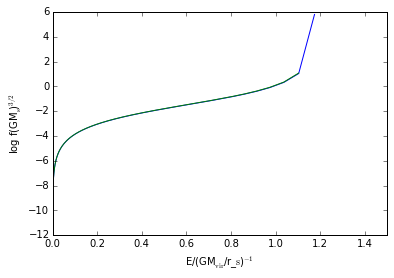

In [30]:
E_const = ((cgs.G * NFW_DF.dprof.M_vir) / NFW_DF.dprof.r_s)**(-1.0)
f_const = (cgs.G  * NFW_DF.dprof.M_vir * NFW_DF.dprof.r_s)**(3.0/2.0)


f_analytical = df.hernquist_df(NFW_DF.E, NFW_DF.dprof.M_sys, NFW_DF.dprof.r_s)

plt.plot(NFW_DF.E*E_const, np.log10(NFW_DF.f * f_const))
plt.plot(NFW_DF.E*E_const, np.log10(f_analytical * f_const))
plt.xlim(0.0,1.5)
plt.ylabel(r'log f(GM$_{\rm{s}}$)$^{3/2}$')
plt.xlabel(r'E/(GM$_{\rm{vir}}$/r_${\rm{s}}$)$^{-1}$')

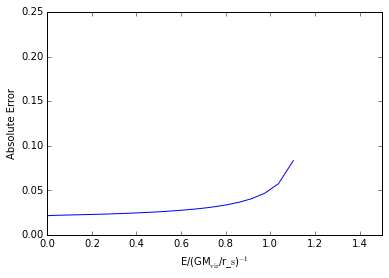

In [31]:
error = (NFW_DF.f - f_analytical)/f_analytical

error = np.abs(error)

plt.plot(NFW_DF.E * E_const, error)
plt.xlabel(r'E/(GM$_{\rm{vir}}$/r_${\rm{s}}$)$^{-1}$')
plt.xlim(0.0,1.5)
plt.ylabel('Absolute Error')

In [32]:
print NFW_DF.E*E_const

[  1.08649486e-04   1.15637348e-04   1.23074638e-04   1.30990263e-04
   1.39414987e-04   1.48381552e-04   1.57924807e-04   1.68081843e-04
   1.78892135e-04   1.90397698e-04   2.02643249e-04   2.15676381e-04
   2.29547747e-04   2.44311258e-04   2.60024295e-04   2.76747925e-04
   2.94547147e-04   3.13491137e-04   3.33653522e-04   3.55112663e-04
   3.77951964e-04   4.02260189e-04   4.28131812e-04   4.55667386e-04
   4.84973929e-04   5.16165340e-04   5.49362848e-04   5.84695474e-04
   6.22300541e-04   6.62324202e-04   7.04922011e-04   7.50259526e-04
   7.98512952e-04   8.49869828e-04   9.04529755e-04   9.62705170e-04
   1.02462218e-03   1.09052141e-03   1.16065900e-03   1.23530753e-03
   1.31475714e-03   1.39931659e-03   1.48931454e-03   1.58510077e-03
   1.68704755e-03   1.79555110e-03   1.91103313e-03   2.03394246e-03
   2.16475678e-03   2.30398451e-03   2.45216677e-03   2.60987946e-03
   2.77773554e-03   2.95638740e-03   3.14652936e-03   3.34890043e-03
   3.56428712e-03   3.79352655e-03

[]

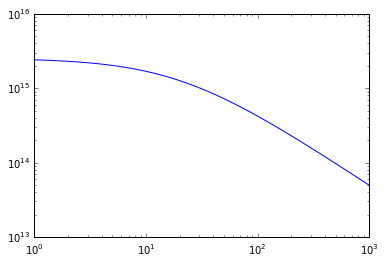

In [33]:
r = np.logspace(0.0,3.0,100.0)*cgs.kpc
rel_pot = NFW_DF.relative_potential(r)

plt.plot(r/cgs.kpc, rel_pot)
plt.loglog()

[]

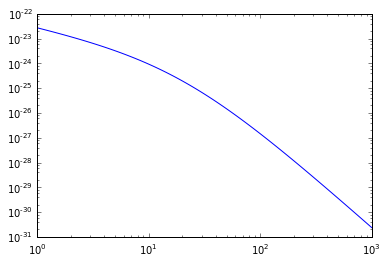

In [34]:
r = np.logspace(0.0,3.0,100.0)*cgs.kpc
density = NFW_DF.dprof.density(r)
plt.plot(r/cgs.kpc, density)
plt.loglog()

[]

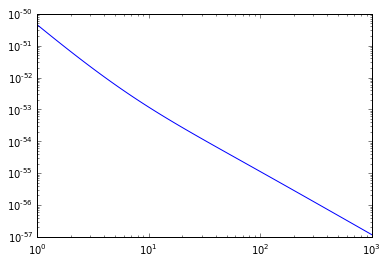

In [35]:
deriv =  NFW_DF._d2rho_dPsi2(r)
plt.plot(r/cgs.kpc,deriv)
plt.loglog()